**Comprehensive Risk Modeling: Value at Risk (VaR), Expected Shortfall, and Model Backtesting**

• Developed and implemented Value at Risk (VaR) models using Historical Simulation, VarianceCovariance, and Monte Carlo Simulation methods, leveraging pandas, numpy & scipy for quantitative computations.
Analyzed portfolio risk exposure and tested the VaR model in different market conditions.

• Conducted rigorous backtesting of VaR models using Traffic Light and Kupiec Tests to assess the
accuracy and reliability of risk predictions. Designed statistical validation techniques to ensure model
robustness and compliance with regulatory frameworks such as Basel III.

• Implemented Expected Shortfall (Conditional VaR) as an advanced risk measure, comparing its
effectiveness against traditional VaR models. Conducted analysis to evaluate risk under tail events,
improving risk management strategies and decision-making processes.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm, chi2

### Define stock tickers and portfolio weights

In [3]:
tickers = ["AAPL", "MSFT", "GOOGL"]
weights = np.array([0.4, 0.35, 0.25])  # Portfolio allocation
start_date = "2020-01-01"
end_date = "2023-12-31"

### Download stock data

In [5]:
df = yf.download(tickers, start=start_date, end=end_date)["Close"]
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,GOOGL,MSFT
Date,,,
2020-01-02,72.620842,68.026024,153.042282
2020-01-03,71.914810,67.670151,151.136673
2020-01-06,72.487854,69.473846,151.527313
2020-01-07,72.146942,69.339645,150.145691
2020-01-08,73.307510,69.833183,152.537308


### Compute daily returns

In [7]:
returns = df.pct_change()
returns.dropna(inplace=True)

### Compute portfolio returns using weighted sum

In [9]:
portfolio_returns = returns @ weights  # Matrix multiplication
portfolio_returns = portfolio_returns.to_frame()
portfolio_returns.columns = ["returns"]  # Explicitly name the column
portfolio_returns.dropna(inplace=True)
portfolio_returns.head()

,returns
Date,
2020-01-03,-0.008833
2020-01-06,0.013162
2020-01-07,-0.004837
2020-01-08,0.012908
2020-01-09,0.015294


### Portfolio parameters

In [11]:
portfolio_value = 100000
confidence_levels = [0.90, 0.95, 0.99]
total_obs = len(portfolio_returns) - 1

### Historical VAR & Expected Shortfall

In [13]:
portfolio_returns_sorted = portfolio_returns.sort_values(by="returns", ascending=True)

In [14]:
for i in confidence_levels:
    alpha = round(1 - i,2)
    historic_var_positions = int(len(portfolio_returns_sorted) * alpha)
    returns_at_specific_positions = portfolio_returns_sorted.iloc[historic_var_positions]['returns']
    historical_var_value = abs(portfolio_value * returns_at_specific_positions)
    print(f"Historical VaR at {i*100}% confidence: ${round(historical_var_value,2)}")
    
    espcted_shortfall_historical = abs(((portfolio_returns_sorted[portfolio_returns_sorted < returns_at_specific_positions]).mean() * portfolio_value).item())
    print(f"Historical ES at {i*100}% confidence: ${round(espcted_shortfall_historical,2)}")

    print("---------------------------------------------------")

Historical VaR at 90.0% confidence: $2131.84
Historical ES at 90.0% confidence: $3408.94
---------------------------------------------------
Historical VaR at 95.0% confidence: $2849.95
Historical ES at 95.0% confidence: $4326.11
---------------------------------------------------
Historical VaR at 99.0% confidence: $4846.68
Historical ES at 99.0% confidence: $6893.6
---------------------------------------------------


### Variance-Covariance VAR & Expected Shortfall

In [50]:
for i in confidence_levels:
    alpha = round(1 - i, 2)
    
    cov_matrix = returns.cov()
    portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)
    
    z_score = abs(norm.ppf(alpha))
    
    variance_covariance_var_value = (z_score * portfolio_std * portfolio_value).item()
    print(f"Var-Cov VaR at {i*100}% confidence: ${round(variance_covariance_var_value, 2)}")
    
    es_var_cov = abs((portfolio_std * portfolio_value) / alpha * norm.pdf(z_score))
    print(f"Var-Cov ES at {i*100}% confidence: ${round(es_var_cov, 2)}")
    
    print("---------------------------------------------------")

Var-Cov VaR at 90.0% confidence: $2449.28
Var-Cov ES at 90.0% confidence: $3354.09
---------------------------------------------------
Var-Cov VaR at 95.0% confidence: $3143.61
Var-Cov ES at 95.0% confidence: $3942.22
---------------------------------------------------
Var-Cov VaR at 99.0% confidence: $4446.07
Var-Cov ES at 99.0% confidence: $5093.7
---------------------------------------------------


### Monte-Carlo VAR & Expected Shortfall

In [20]:
# ---------------- MONTE CARLO VaR & EXPECTED SHORTFALL ----------------
num_simulations = 10000
time_horizon = 1  # 1-day

# Generate random normal returns
random_shocks = np.random.normal(0, 1, num_simulations)

# Compute Monte Carlo simulated returns using Geometric Brownian Motion (GBM)
mu = portfolio_returns["returns"].mean()
sigma = portfolio_returns["returns"].std()

simulated_returns = np.exp((mu - 0.5 * sigma**2) * time_horizon + sigma * np.sqrt(time_horizon) * random_shocks) - 1
simulated_portfolio_values = portfolio_value * (1 + simulated_returns)

# Sort simulated portfolio returns
sorted_simulated_returns = np.sort(simulated_portfolio_values - portfolio_value)

for i in confidence_levels:
    alpha = 1 - i
    var_position = int(alpha * num_simulations)

    # Monte Carlo VaR
    monte_carlo_var = abs(sorted_simulated_returns[var_position])
    print(f"MC VAR at {i*100}% confidence: ${round(monte_carlo_var,2)}")
    # Monte Carlo Expected Shortfall (ES)
    es_monte_carlo = abs(sorted_simulated_returns[:var_position].mean())  # Average of worst losses
    print(f"MC ES at {i*100}% confidence: ${round(es_monte_carlo,2)}")

    print("---------------------------------------------------")

MC VAR at 90.0% confidence: $2319.39
MC ES at 90.0% confidence: $3205.27
---------------------------------------------------
MC VAR at 95.0% confidence: $3001.32
MC ES at 95.0% confidence: $3779.71
---------------------------------------------------
MC VAR at 99.0% confidence: $4277.95
MC ES at 99.0% confidence: $4852.72
---------------------------------------------------


# Backtesting Historical VAR

### Method 1: Traffic-light method

In [22]:
backtest_days = 252  # Used last 252 trading days for backtesting
backtest_returns = portfolio_returns[-backtest_days:]

In [23]:
historical_var_values = {"90%": 2131.84, "95%": 3143.61, "99%": 4446.07}

In [24]:
absolute_actual_returns = abs(backtest_returns["returns"] * portfolio_value) 

In [25]:
for confidence, var_value in historical_var_values.items():
    breach_count = (absolute_actual_returns >= var_value).sum().item()  # Convert to scalar

    # Assign traffic light colors
    if breach_count <= 4:
        risk_category = "Green Zone (Low Risk)"
    elif 5 <= breach_count <= 9:
        risk_category = "Yellow Zone (Moderate Risk)"
    else:
        risk_category = "Red Zone (High Risk)"

    # Print results
    print(f"Confidence Level: {confidence}")
    print(f"VaR Breaches: {breach_count}")
    print(f"Risk Category: {risk_category}")
    print("-------------------------------------------")

Confidence Level: 90%
VaR Breaches: 27
Risk Category: Red Zone (High Risk)
-------------------------------------------
Confidence Level: 95%
VaR Breaches: 6
Risk Category: Yellow Zone (Moderate Risk)
-------------------------------------------
Confidence Level: 99%
VaR Breaches: 1
Risk Category: Green Zone (Low Risk)
-------------------------------------------


### Method 2: Kupiec Test

In [67]:
from scipy.stats import chi2

# -------------------- Define Parameters --------------------
backtest_days = 252  # Last 252 trading days
backtest_returns = portfolio_returns[-backtest_days:]  # Select last 252 days

# Define VaR thresholds
historical_var_values = {
    "90%": 2131.84,
    "95%": 3143.61,
    "99%": 4446.07
}

# Convert portfolio returns into absolute dollar losses
absolute_actual_returns = abs(backtest_returns["returns"] * portfolio_value)  # Ensure it's a Series

# -------------------- Kupiec Test --------------------
for confidence, var_value in historical_var_values.items():
    alpha = 1 - (int(confidence.strip('%')) / 100)  # Convert confidence to failure probability
    expected_failures = backtest_days * alpha  # Expected breaches
    actual_failures = (absolute_actual_returns >= var_value).sum().item()  # Actual breaches

    # Compute Kupiec Likelihood Ratio (LR)
    p = alpha
    x = actual_failures
    n = backtest_days

    likelihood_ratio = -2 * ((n - x) * np.log(1 - p) + x * np.log(p) - (n - x) * np.log(1 - x/n) - x * np.log(x/n))

    # Compare LR with chi-square critical value (df = 1, 95% significance level)
    chi_square_critical = chi2.ppf(0.95, df=1)

    # Decision
    if likelihood_ratio > chi_square_critical:
        decision = "Reject VaR model (Inaccurate)"
    else:
        decision = "Accept VaR model (Valid)"

    # Print results
    print(f"Confidence Level: {confidence}")
    print(f"Expected Breaches: {round(expected_failures,2)}")
    print(f"Actual Breaches: {actual_failures}")
    print(f"Likelihood Ratio (LR): {round(likelihood_ratio,2)}")
    print(f"Chi-Square Critical Value: {round(chi_square_critical,2)}")
    print(f"Decision: {decision}")
    print("-----------------------------------------------")

Confidence Level: 90%
Expected Breaches: 25.2
Actual Breaches: 27
Likelihood Ratio (LR): 0.14
Chi-Square Critical Value: 3.84
Decision: Accept VaR model (Valid)
-----------------------------------------------
Confidence Level: 95%
Expected Breaches: 12.6
Actual Breaches: 6
Likelihood Ratio (LR): 4.48
Chi-Square Critical Value: 3.84
Decision: Reject VaR model (Inaccurate)
-----------------------------------------------
Confidence Level: 99%
Expected Breaches: 2.52
Actual Breaches: 1
Likelihood Ratio (LR): 1.2
Chi-Square Critical Value: 3.84
Decision: Accept VaR model (Valid)
-----------------------------------------------


### Plotting Portfolio Returns Distribution with Historical VaR Thresholds

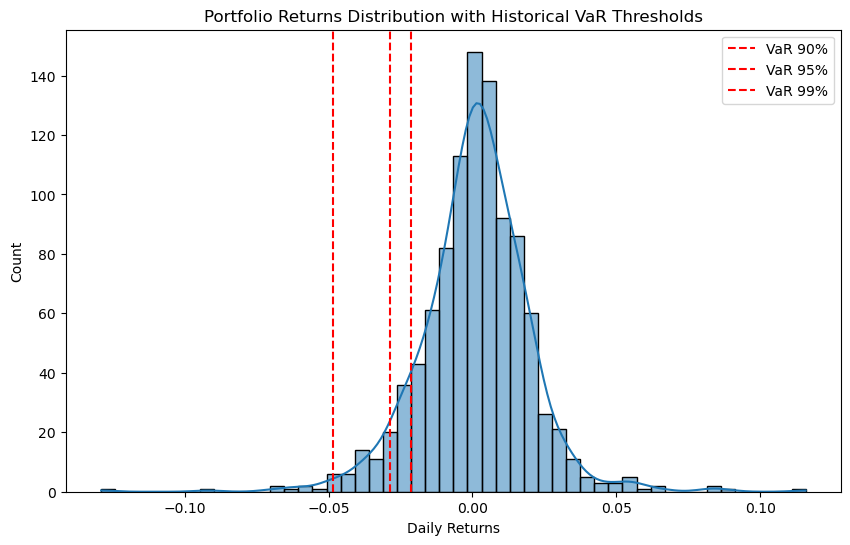

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
historical_var_values = {"90%": 2131.84, "95%": 2849.95, "99%": 4846.68}

# Plot portfolio returns distribution with VaR thresholds
plt.figure(figsize=(10, 6))
sns.histplot(portfolio_returns["returns"], bins=50, kde=True)

for conf, var in historical_var_values.items():
    var_return = -var / portfolio_value
    plt.axvline(x=var_return, color='r', linestyle='--', label=f'VaR {conf}')

plt.title("Portfolio Returns Distribution with Historical VaR Thresholds")
plt.xlabel("Daily Returns")
plt.legend()
plt.show()

### **Method Comparison**

**99% VaR:**
- **Historical**: **$4,847** (most conservative) 
- **Var-Cov**: **$4,446** (underestimates by **8.3%** vs Historical)
- **Monte Carlo**: **$4,278** (**11.7%** lower than Historical)
- **ES consistently exceeds VaR by 30-42%** at 99% confidence

### **Backtesting Results**

**90% VaR:**
- **27 breaches** (vs **25.2** expected)
- **7.1% breach rate** (vs **10%** expected)

**95% VaR:**
- **6 breaches** (vs **12.6** expected)
- **2.4% breach rate** (vs **5%** expected)

**99% VaR:**
- **1 breach** (vs **2.52** expected)
- **0.4% breach rate** (vs **1%** expected)

### **Model Validation**

**Kupiec Test:**
- **95% VaR rejected** (LR=**4.48** > **3.84** critical value)
- **90% and 99% VaR accepted** (LR=**0.14** and **1.20** respectively)